# Pass Rates Quality Control

We parsed the data at `parse.ipynb`, but that was just the first step. How do we know the data was correctly parsed? The current notebook serves that purpose.

The strategy is to compare the sum of each extracted column with the summary row or other PDF sources. Pass rates requires an extra step, namely, calculating the number of exams passed `(exams passed = rate * exams done)`, and then comparing the sum of this extra column with the summary.

A few things complicate the task:
- Each yearly PDF release was done slightly differently, so the way in which we check if data was correctly parsed also differs.
- Data inconsistencies show up in the PDF.

The point of this step is to check if data was parsed correctly, **we will not be fixing any data**.

In [2]:
import pandas as pd
import math

In [142]:
summaries = pd.read_pickle("summaries.pkl")
pass_rates_tables = pd.read_pickle("parsed-data/db.pkl")

## 2015

In [3]:
summary2015 = summaries.loc["2015",1099]
summary2015

nec                       <NA>
name_raw           Total Geral
t_scheduled             181897
t_done                  176487
t_rate                  0.7157
d_scheduled             185379
d_done                  181441
d_rate                  0.6957
total_scheduled         367276
total_done              357928
total_rate              0.7055
Name: (2015, 1099), dtype: object

In [4]:
pass_rates_2015 = pass_rates_tables.loc["2015"].copy()

assert(summary2015["d_done"] == pass_rates_2015["d_done"].sum())
assert(summary2015["t_done"] == pass_rates_2015["t_done"].sum())
assert(summary2015["total_done"] == pass_rates_2015["total_done"].sum())
assert(summary2015["d_scheduled"] == pass_rates_2015["d_scheduled"].sum())
assert(summary2015["t_scheduled"] == pass_rates_2015["t_scheduled"].sum())
assert(summary2015["total_scheduled"] == pass_rates_2015["total_scheduled"].sum())

Checking the pass rates columns requires a bit more work, as we want to derive the number of exams approved and compare that with the summary. 

In [5]:
# Theory pass rates columns first
theory_passed_2015 = pass_rates_2015['t_done'].multiply(pass_rates_2015['t_rate'], fill_value = 0).sum()
summary_theory_passed_2015 = summary2015.loc["t_done"] * summary2015.loc["t_rate"]

assert(round(theory_passed_2015) == round(summary_theory_passed_2015))

Applying the same logic to the driving pass rate columns shows that our aggregate is off by 45 exams passed. 

In [6]:
driving_passed_2015 = int(pass_rates_2015['d_done'].multiply(pass_rates_2015['d_rate'], fill_value = 0).sum())
summary_driving_passed_2015 = int(summary2015.loc["d_done"] * summary2015.loc["d_rate"])
print("Driving passed is off by", summary_driving_passed_2015 - driving_passed_2015, "exams.")

Driving passed is off by 45 exams.


A rounding error would be a much smaller deviation. 
We have an accuracy of 2 decimal places, which means the actual pass rate can go anywhere from 0.69565 to 0.69574. That gives us a much smaller deviation than the one we found.

In [7]:
summary2015.loc["d_done"] * (0.69574 - 0.69565)

16.32969000000626

Let's now check for internal consistency by calculating a new total pass rate column, derived from the previous two. Any deviation should give us a clue to what the bad row is.

In [8]:
pass_rates_2015["total_rate_calculated"] = (pass_rates_2015["t_done"].multiply(pass_rates_2015["t_rate"],fill_value = 0)
                                            .add(pass_rates_2015["d_done"].multiply(pass_rates_2015["d_rate"],fill_value = 0))
                                            .divide(pass_rates_2015["d_done"].add(pass_rates_2015["t_done"])))

for index, row in pass_rates_2015.iterrows():
    if pd.isna(row["total_rate"]) or pd.isna(row["total_rate_calculated"]):
        print(row.name)
    elif  abs(row["total_rate_calculated"] - row["total_rate"]) > 0.0001:
        print(row.name)

regimento-de-sapadores-bombeiros-de-lisboa-03006
sind-xxxxx


These two rows have discrepancies, so lets look at them

In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pass_rates_2015.loc["regimento-de-sapadores-bombeiros-de-lisboa-03006"]

nec                                                                   3006
name_raw                 Escola Do Regimento De Sapadores Bombeiros De ...
t_scheduled                                                            0.0
t_done                                                                 0.0
t_rate                                                                 NaN
d_scheduled                                                             38
d_done                                                                  37
d_rate                                                                 NaN
total_scheduled                                                         38
total_done                                                              37
total_rate                                                             1.0
total_passed                                                           0.0
total_rate_calculated                                                  0.0
Name: regimento-de-sapado

In [10]:
pass_rates_2015.loc["sind-xxxxx"]

nec                        <NA>
name_raw                 S/IND.
t_scheduled              1445.0
t_done                   1295.0
t_rate                   0.7228
d_scheduled                   0
d_done                     <NA>
d_rate                      NaN
total_scheduled            1445
total_done                 1295
total_rate               0.7228
total_passed              936.0
total_rate_calculated      <NA>
Name: sind-xxxxx, dtype: object

The issue is that school 3006 has a theory pass rate of 0, a driving pass rate of NaN and a total_rate of 1. This is inconsistent, so let's remove this school from the data set and fix the pass rate.

We'll redo the calcs assuming the summary pass rate would remain approximate with one less school. 

In [11]:
pass_rates_2015_ = pass_rates_2015.drop(index="regimento-de-sapadores-bombeiros-de-lisboa-03006")

In [12]:
# "_" just means corrected
driving_passed_2015_ = int(pass_rates_2015_['d_done'].multiply(pass_rates_2015_['d_rate'], fill_value = 0).sum())
summary_driving_passed_2015_ = int((summary2015.loc["d_done"] - 37 )* summary2015.loc["d_rate"]) 
print("Driving passed is off by", summary_driving_passed_2015_ - driving_passed_2015_, "exams.")

Driving passed is off by 19 exams.


Which is much closer to the tolerance of 16 exams we calculated above. Applying the same logic to total rates.

In [13]:
total_passed_2015_ = int(pass_rates_2015_['total_done'].multiply(pass_rates_2015_['total_rate'], fill_value = 0).sum())
summary_total_passed_2015_ = int((summary2015.loc["total_done"] - 37 )* summary2015.loc["total_rate"]) 
print("Total passed is off by", abs(summary_total_passed_2015_ - total_passed_2015_), "exams.")

Total passed is off by 3 exams.


It's satisfactory given that we're extracting rounded numbers. 

# 2016

In [43]:
summary2016 = summaries.loc["2016",1115]

In [14]:
pass_rates_2016 = pass_rates_tables.loc["2016"].copy()

assert(summary2016["d_done"] == pass_rates_2016["d_done"].sum())
assert(summary2016["t_done"] == pass_rates_2016["t_done"].sum())
assert(summary2016["total_done"] == pass_rates_2016["total_done"].sum())
assert(summary2016["d_scheduled"] == pass_rates_2016["d_scheduled"].sum())
assert(summary2016["t_scheduled"] == pass_rates_2016["t_scheduled"].sum())
assert(summary2016["total_scheduled"] == pass_rates_2016["total_scheduled"].sum())

In [30]:
theory_passed_2016 = pass_rates_2016['t_done'].multiply(pass_rates_2016['t_rate'], fill_value = 0).sum()
summary_theory_passed_2016 = summary2016.loc["t_done"] * summary2016.loc["t_rate"]

assert(abs(theory_passed_2016 - summary_theory_passed_2016) < 4) 

In [38]:
driving_passed_2016 = int(pass_rates_2016['d_done'].multiply(pass_rates_2016['d_rate'], fill_value = 0).sum())
summary_driving_passed_2016 = int(summary2016.loc["d_done"] * summary2016.loc["d_rate"])
assert(abs(driving_passed_2016 - summary_driving_passed_2016) < 5)

In [42]:
total_passed_2016 = int(pass_rates_2016['total_done'].multiply(pass_rates_2016['total_rate'], fill_value = 0).sum())
summary_total_passed_2016 = int(summary2016.loc["total_done"] * summary2016.loc["total_rate"])
assert(abs(total_passed_2016 - summary_total_passed_2016) < 19) 

# 2017

In [50]:
summary2017 = summaries.loc["2017", 1133]
pass_rates_2017 = pass_rates_tables.loc["2017"].copy()

In [52]:
assert(summary2017["d_done"] == pass_rates_2017["d_done"].sum())
assert(summary2017["t_done"] == pass_rates_2017["t_done"].sum())
assert(summary2017["d_scheduled"] == pass_rates_2017["d_scheduled"].sum())
assert(summary2017["t_scheduled"] == pass_rates_2017["t_scheduled"].sum())

In [57]:
theory_passed_2017 = pass_rates_2017['t_done'].multiply(pass_rates_2017['t_rate'], fill_value = 0).sum()
summary_theory_passed_2017 = summary2017.loc["t_done"] * summary2017.loc["t_rate"]

assert(abs(theory_passed_2017 - summary_theory_passed_2017) < 8)

In [60]:
driving_passed_2017 = int(pass_rates_2017['d_done'].multiply(pass_rates_2017['d_rate'], fill_value = 0).sum())
summary_driving_passed_2017 = int(summary2017.loc["d_done"] * summary2017.loc["d_rate"])
assert(abs(driving_passed_2017 - summary_driving_passed_2017) < 5)

In [68]:
total_passed_2017 = int(pass_rates_2017['total_done'].multiply(pass_rates_2017['total_rate'], fill_value = 0).sum())
summary_total_passed_2017 = int(summary2017.loc["total_done"] * summary2017.loc["total_rate"])
assert(abs(total_passed_2017 - summary_total_passed_2017) < 7) 

# 2018

In [72]:
summary2018 = summaries.loc["2018", 1144]
pass_rates_2018 = pass_rates_tables.loc["2018"].copy()

In [73]:
assert(summary2018["d_done"] == pass_rates_2018["d_done"].sum())
assert(summary2018["t_done"] == pass_rates_2018["t_done"].sum())
assert(summary2018["d_scheduled"] == pass_rates_2018["d_scheduled"].sum())

In [76]:
print( "missing", pass_rates_2018["t_scheduled"].sum() - summary2018["t_scheduled"],  "exam, no idea why...")

missing 1.0 exam, no idea why...


In [112]:
theory_passed_2018 = pass_rates_2018['t_done'].multiply(pass_rates_2018['t_rate'], fill_value = 0).sum()
summary_theory_passed_2018 = summary2018.loc["t_done"] * summary2018.loc["t_rate"]

assert(abs(theory_passed_2018 - summary_theory_passed_2018) < 7)

driving_passed_2018 = int(pass_rates_2018['d_done'].multiply(pass_rates_2018['d_rate'], fill_value = 0).sum())
summary_driving_passed_2018 = int(summary2018.loc["d_done"] * summary2018.loc["d_rate"])
assert(abs(driving_passed_2018 - summary_driving_passed_2018) < 3)

total_passed_2018 = int(pass_rates_2018['total_done'].multiply(pass_rates_2018['total_rate'], fill_value = 0).sum())
summary_total_passed_2018 = int(summary2018.loc["total_done"] * summary2018.loc["total_rate"])
assert(abs(total_passed_2018 - summary_total_passed_2018) < 8) 

# 2019

In [119]:
summary2019 = summaries.loc["2019", 1145]
pass_rates_2019 = pass_rates_tables.loc["2019"].copy()

In [120]:
assert(summary2019["d_done"] == pass_rates_2019["d_done"].sum())
assert(summary2019["t_done"] == pass_rates_2019["t_done"].sum())
assert(summary2019["d_scheduled"] == pass_rates_2019["d_scheduled"].sum())
assert(summary2019["t_scheduled"] == pass_rates_2019["t_scheduled"].sum())

In [139]:
theory_passed_2019 = pass_rates_2019['t_done'].multiply(pass_rates_2019['t_rate'], fill_value = 0).sum()
summary_theory_passed_2019 = summary2019.loc["t_done"] * summary2019.loc["t_rate"]

assert(abs(theory_passed_2019 - summary_theory_passed_2019) < 5)

driving_passed_2019 = int(pass_rates_2019['d_done'].multiply(pass_rates_2019['d_rate'], fill_value = 0).sum())
summary_driving_passed_2019 = int(summary2019.loc["d_done"] * summary2019.loc["d_rate"])
assert(abs(driving_passed_2019 - summary_driving_passed_2019) < 6)

total_passed_2019 = int(pass_rates_2019['total_done'].multiply(pass_rates_2019['total_rate'], fill_value = 0).sum())
summary_total_passed_2019 = int(summary2019.loc["total_done"] * summary2019.loc["total_rate"])
assert(abs(total_passed_2019 - summary_total_passed_2019) < 6) 

# 2020

In [144]:
pass_rates_2020 = pass_rates_tables.loc["2020"].copy()

Comparing with aggregates at [categories-2020](https://www.imt-ip.pt/sites/IMTT/Portugues/EnsinoConducao/taxasdeaprovacao/Documents/ANO%202020/categorias-2020.pdf
). Differences are maybe due to a missing school.

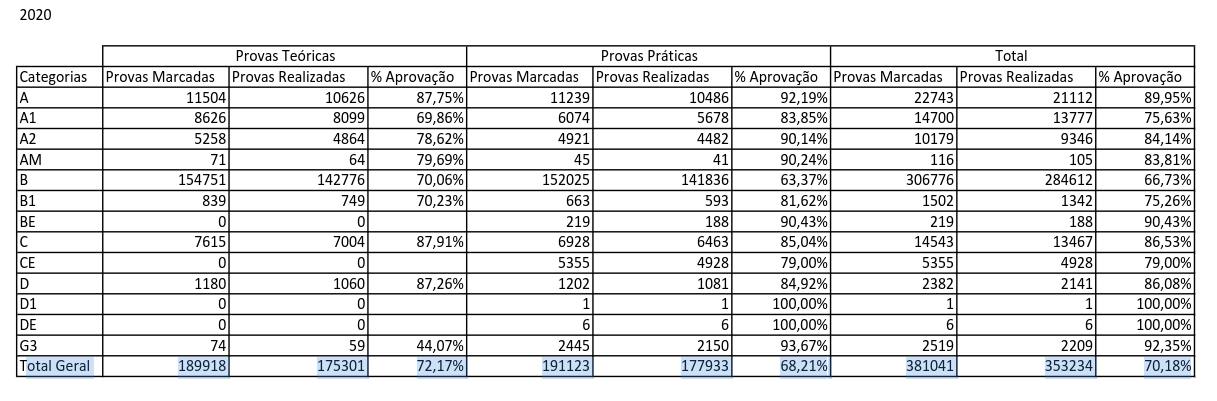

In [180]:
print("Theory Scheduled", pass_rates_2020["t_scheduled"].sum(), "aggregates: 189918")
assert(pass_rates_2020["t_done"].sum() == 175301)
print("Total scheduled", pass_rates_2020["total_scheduled"].sum(), "aggregates: 381041")
print("Driving Scheduled", pass_rates_2020["d_scheduled"].sum(), "aggregates: 191123")
print("Driving done", pass_rates_2020["d_done"].sum(), "aggregates: 177933")
print("Total done", pass_rates_2020["total_done"].sum(), "aggregates: 353234")


theory_passed_2020 = pass_rates_2020['t_done'].multiply(pass_rates_2020['t_rate'], fill_value = 0).sum()
summary_theory_passed_2020 = 175301 *0.7217

assert(abs(theory_passed_2020 - summary_theory_passed_2020) < 8)

driving_passed_2020 = int(pass_rates_2020['d_done'].multiply(pass_rates_2020['d_rate'], fill_value = 0).sum())
summary_driving_passed_2020 = 177933 * 0.6821
assert(abs(driving_passed_2020 - summary_driving_passed_2020) < 12)

total_passed_2020 = int(pass_rates_2020['total_done'].multiply(pass_rates_2020['total_rate'], fill_value = 0).sum())
summary_total_passed_2020 = 353234 * 0.7018
assert(abs(total_passed_2020 - summary_total_passed_2020) < 22) 

Theory Scheduled 189913.0 aggregates: 189918
Total scheduled 381027 aggregates: 381041
Driving Scheduled 191114 aggregates: 191123
Driving done 177924 aggregates: 177933
Total done 353225 aggregates: 353234
